In [1]:
import os
import zipfile
import shutil
from pathlib import Path
import matplotlib.pyplot as plt

zip_path = "/content/drive/MyDrive/data.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

In [2]:
chicken_dir = "/content/data/chicken-images"
duck_dir = "/content/data/duck-images"
category_dirs = [chicken_dir, duck_dir]

In [3]:
import os
import pandas as pd

def build_image_dataframe(category_folders: list[str]):

    data_splits = {"train": [], "val": [], "test": []}

    for category_folder in category_folders:
        label = os.path.basename(category_folder)

        for split in data_splits.keys():
            split_dir = os.path.join(category_folder, split)
            if not os.path.exists(split_dir):
                continue

            image_files = [
                os.path.join(split_dir, f)
                for f in os.listdir(split_dir)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ]

            for img_path in image_files:
                data_splits[split].append({"filepath": img_path, "label": label})

    # Convert to DataFrames
    df_train = pd.DataFrame(data_splits["train"])
    df_val = pd.DataFrame(data_splits["val"])
    df_test = pd.DataFrame(data_splits["test"])

    return df_train, df_val, df_test

df_train, df_val, df_test = build_image_dataframe(category_dirs)



<ipython-input-4-0c12e7038543>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="Set2")


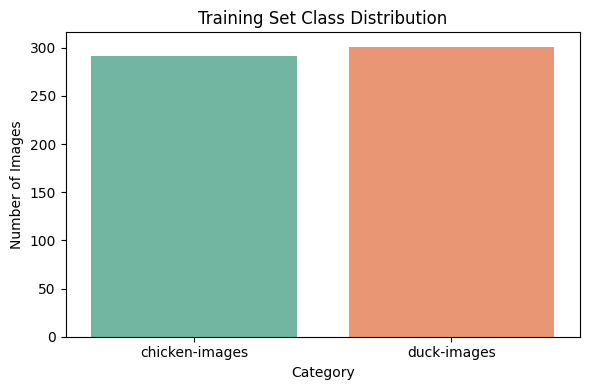

<ipython-input-4-0c12e7038543>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="Set2")


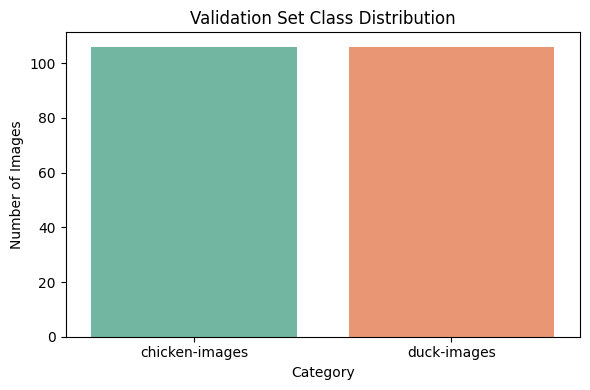

<ipython-input-4-0c12e7038543>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="Set2")


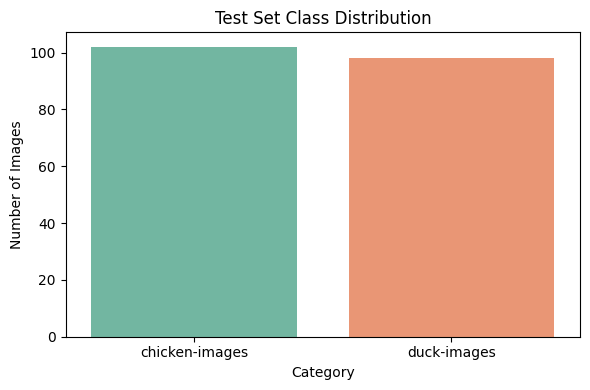

In [4]:
import seaborn as sns

def visualize_class_counts(df: pd.DataFrame, dataset_name: str):
    plt.figure(figsize=(6, 4))
    sns.countplot(x="label", data=df, palette="Set2")
    plt.title(f"{dataset_name} Class Distribution")
    plt.xlabel("Category")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()

# Plotting each split
visualize_class_counts(df_train, "Training Set")
visualize_class_counts(df_val, "Validation Set")
visualize_class_counts(df_test, "Test Set")

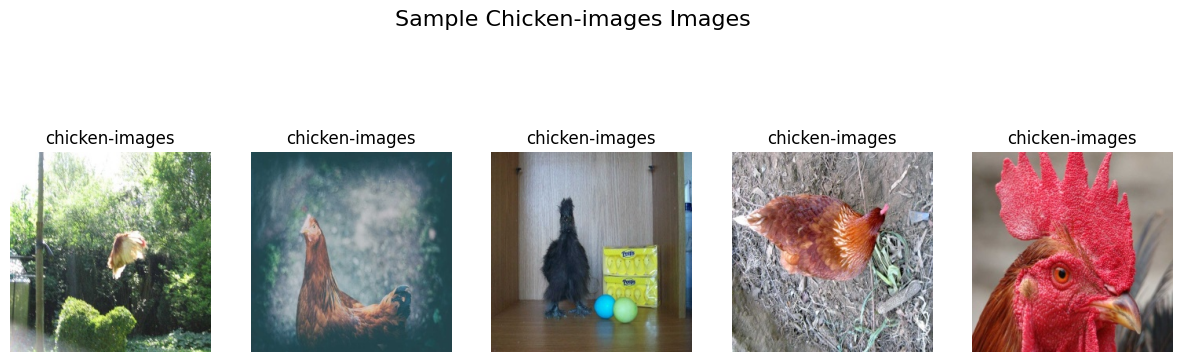

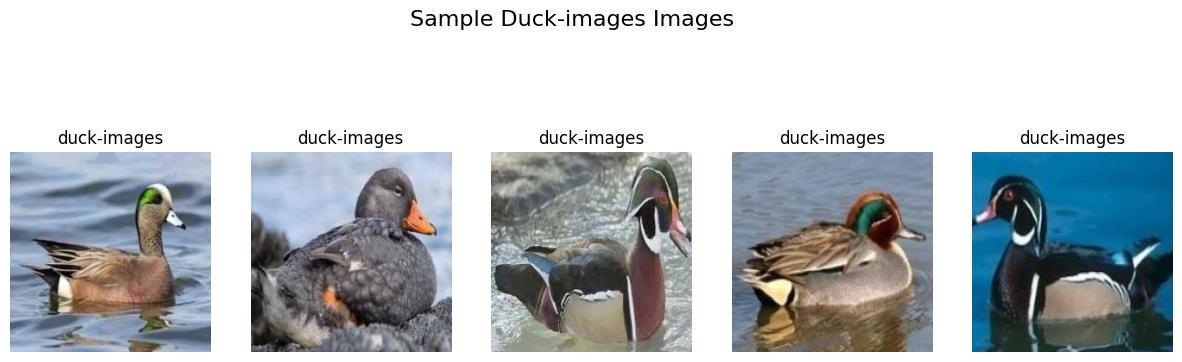

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualize_images(df, label, num_images=5):
    # Filter dataframe by label
    sample_df = df[df['label'] == label].sample(n=num_images, random_state=120)

    # Plot images
    plt.figure(figsize=(15, 5))
    for i, row in enumerate(sample_df.itertuples(), 1):
        img = mpimg.imread(row.filepath)
        plt.subplot(1, num_images, i)
        plt.imshow(img)
        plt.title(f"{label}")
        plt.axis('off')
    plt.suptitle(f"Sample {label.capitalize()} Images", fontsize=16)
    plt.show()

# Visualize chickens and ducks
visualize_images(df_train, label="chicken-images", num_images=5)
visualize_images(df_train, label="duck-images", num_images=5)


In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import random

class PoultryDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepath']
        label_str = self.dataframe.iloc[idx]['label']
        label = 1 if label_str == 'chicken-images' else 0

        img = Image.open(img_path).convert("RGB").resize((224, 224))

        if self.transform:
            img = self.transform(img)

        return img, label


In [7]:
mean_vals = [0.485, 0.456, 0.406]
std_vals = [0.229, 0.224, 0.225]

data_augmentations = {
    "train": transforms.Compose([
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_vals, std=std_vals),
    ]),
    "val": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_vals, std=std_vals),
    ]),
}


In [8]:
train_set = PoultryDataset(df_train, transform=data_augmentations["train"])
val_set = PoultryDataset(df_val, transform=data_augmentations["val"])
test_set = PoultryDataset(df_test, transform=data_augmentations["val"])

BATCH_SIZE = 16
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)


Using device: cuda


In [9]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch.optim as optim
import time
from tempfile import TemporaryDirectory

model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


In [10]:
from tqdm import tqdm


Epoch 1/10
----------------------------------------


Train Loss: 0.3256, Acc: 0.8395


Val Loss: 0.0473, Acc: 0.9906

Epoch 2/10
----------------------------------------


Train Loss: 0.0489, Acc: 0.9916


Val Loss: 0.0410, Acc: 0.9858

Epoch 3/10
----------------------------------------


Train Loss: 0.0540, Acc: 0.9848


Val Loss: 0.0775, Acc: 0.9717

Epoch 4/10
----------------------------------------


Train Loss: 0.0341, Acc: 0.9949


Val Loss: 0.0228, Acc: 0.9906

Epoch 5/10
----------------------------------------


Train Loss: 0.0186, Acc: 0.9932


Val Loss: 0.0232, Acc: 0.9858

Epoch 6/10
----------------------------------------


Train Loss: 0.0227, Acc: 0.9949


Val Loss: 0.0401, Acc: 0.9764

Epoch 7/10
----------------------------------------


Train Loss: 0.0096, Acc: 1.0000


Val Loss: 0.0291, Acc: 0.9858

Epoch 8/10
----------------------------------------


Train Loss: 0.0129, Acc: 0.9983


Val Loss: 0.0220, Acc: 0.9906

Epoch 9/10
----------------------------------------


Train Loss: 0.0135, Acc: 0.9983


Val Loss: 0.0212, Acc: 0.9906

Epoch 10/10
----------------------------------------


Train Loss: 0.0064, Acc: 1.0000


Val Loss: 0.0305, Acc: 0.9811

----------------------------------------
Training complete in 1m 1s
Best validation accuracy: 0.9906


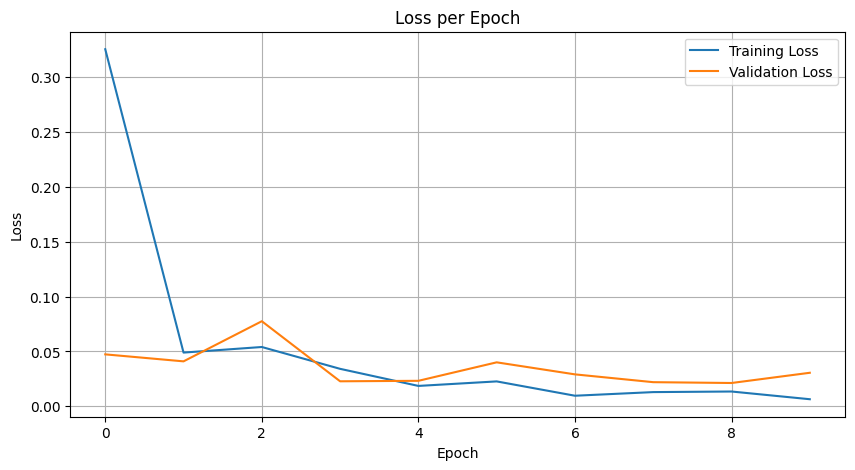

In [11]:
def run_training(model, criterion, optimizer, scheduler, num_epochs=15):
    best_acc = 0.0
    since = time.time()

    train_len = len(train_loader.dataset)
    val_len = len(val_loader.dataset)

    train_losses = []
    val_losses = []

    with TemporaryDirectory() as temp_dir:
        best_model_path = os.path.join(temp_dir, 'checkpoint.pt')
        torch.save(model.state_dict(), best_model_path)

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 40)

            epoch_train_loss = 0.0
            epoch_val_loss = 0.0

            for phase in ['train', 'val']:
                is_train = (phase == 'train')
                model.train() if is_train else model.eval()

                loader = train_loader if is_train else val_loader
                running_loss, correct = 0.0, 0

                loop = tqdm(loader, desc=f"{phase.title()} Batches", leave=False)
                for images, labels in loop:
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(is_train):
                        outputs = model(images)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if is_train:
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * images.size(0)
                    correct += torch.sum(preds == labels.data).item()
                    loop.set_postfix(loss=loss.item())

                epoch_loss = running_loss / (train_len if is_train else val_len)
                epoch_acc = correct / (train_len if is_train else val_len)
                print(f"{phase.title()} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

                if is_train:
                    train_losses.append(epoch_loss)
                else:
                    val_losses.append(epoch_loss)
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        torch.save(model.state_dict(), best_model_path)

            scheduler.step()

        print("\n" + "-"*40)
        print(f"Training complete in {(time.time() - since)//60:.0f}m {(time.time() - since)%60:.0f}s")
        print(f"Best validation accuracy: {best_acc:.4f}")

        model.load_state_dict(torch.load(best_model_path))

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

# Train the model
model = run_training(model, criterion, optimizer, lr_scheduler, num_epochs=10)


              precision    recall  f1-score   support

        duck       0.98      1.00      0.99        98
     chicken       1.00      0.98      0.99       102

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



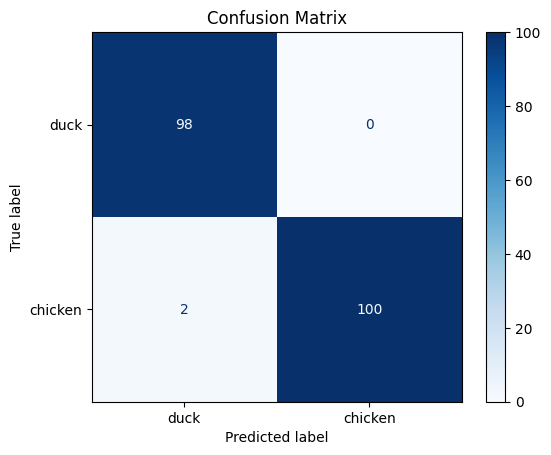

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, loader):
    model.eval()
    preds_list, labels_list = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    return preds_list, labels_list

preds, actuals = evaluate_model(model, test_loader)

# Classification report
print(classification_report(actuals, preds, target_names=["duck", "chicken"]))

# Confusion matrix
cm = confusion_matrix(actuals, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["duck", "chicken"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()
